In [1]:
import pandas as pd
import os
import librosa
import numpy as np
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import pandas as pd
import numpy as np


import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from tqdm.notebook import tqdm

from sklearn.preprocessing import OneHotEncoder

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
X = np.load('log_melspec_X_data.npy')
Y = np.load('log_melspec_Y_data.npy', allow_pickle='True')

In [3]:
Y_df = pd.DataFrame(Y)
Y_df.head()

,0
0,An-Nas
1,An-Nas
2,An-Nas
3,An-Nas
4,An-Nas


In [4]:
X_df = pd.DataFrame(X)
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-14.912743,-10.509667,-11.212726,-13.802998,-14.849165,6.806949,16.539665,10.523086,-4.896206,-16.432079,...,-52.203300,-52.203300,-52.203300,-52.203300,-52.203300,-52.203300,-52.203300,-52.203300,-52.203300,-52.203300
1,-14.956661,-9.657782,-10.150836,-12.684127,-8.091335,4.647990,14.930429,11.608740,-4.548166,-13.859034,...,-53.024529,-53.029858,-53.034473,-53.038361,-53.041702,-53.044544,-53.046551,-53.047897,-53.048847,-53.049458
2,-14.980775,-10.588456,-11.141933,-13.374152,-16.557209,-0.928026,10.888081,10.455920,2.669600,-8.516095,...,-52.417393,-52.419598,-52.421520,-52.423168,-52.424591,-52.425797,-52.426773,-52.427551,-52.428112,-52.428455
3,-14.090482,-9.505132,-9.275669,-11.789614,-9.203239,9.184479,18.451992,13.802429,-8.251540,-18.656193,...,-53.681873,-53.689995,-53.697063,-53.703037,-53.708202,-53.712601,-53.716118,-53.718952,-53.720943,-53.721989
4,-18.108946,-14.981512,-12.698249,3.383987,16.519243,10.660097,-0.658719,-5.584931,7.193225,11.985046,...,-47.312172,-47.312172,-47.312172,-47.312172,-47.312172,-47.312172,-47.312172,-47.312172,-47.312172,-47.312172


Unison Shuffling

In [5]:
import numpy 


def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = numpy.empty(a.shape, dtype=a.dtype)
    shuffled_b = numpy.empty(b.shape, dtype=b.dtype)
    permutation = numpy.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [6]:
X_pre, y_pre = shuffle_in_unison(X, Y)

In [7]:
print(X_pre.shape)
print(y_pre.shape)

(248, 128)
(248,)


One Hot Encoding

In [8]:
labels = ['An-Nas', 'Al-Falaq']

In [9]:
y_enc = np.array([labels.index(l) for l in y_pre])
y_enc = tf.one_hot(y_enc, len(labels))

In [10]:
print(y_enc.shape)

(248, 2)


Train-Test Split

In [11]:
def train_test_split(X, y, test_size):
    n_test = int(X.shape[0] * test_size)
    X_test = X[:n_test]
    y_test = y[:n_test]
    X_train = X[n_test:]
    y_train = y[n_test:]
    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_pre, y_enc, 0.1)

In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(224, 128) (224, 2)
(24, 128) (24, 2)


Expand Dimension for CNN-1D, CNN-2D and Transformers

In [14]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis = 2)

print("Shape of X Train", X_train.shape)
print("Shape of X Test", X_test.shape)

Shape of X Train (224, 128, 1)
Shape of X Test (24, 128, 1)


Reshape for Only Transformer Models and CNN-2D Models

In [15]:
X_train_reshaped = X_train.reshape(X_train.shape[0], 16, 8, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 16, 8, 1)

print(X_train_reshaped.shape, y_train.shape)
print(X_test_reshaped.shape, y_test.shape)

(224, 16, 8, 1) (224, 2)
(24, 16, 8, 1) (24, 2)


- - CNN 1D Model

In [16]:
import IPython.display as ipd
import librosa
import librosa.display
import pandas as pd
import os, time, warnings
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
)

from keras import regularizers
warnings.filterwarnings("ignore")

In [17]:
CNN1D_Model = Sequential()
CNN1D_Model.add(
    Conv1D(
        256,
        5,
        strides=1,
        padding="same",
        activation="relu",
        input_shape=(X_train.shape[1], 1),
    )
)
CNN1D_Model.add(BatchNormalization())
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(128, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(64, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Flatten())
CNN1D_Model.add(Dense(units=1024, activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(Dense(units=2, activation="softmax"))
CNN1D_Model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 256)          1536      
                                                                 
 batch_normalization (BatchN  (None, 128, 256)         1024      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 64, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 64, 256)           327936    
                                                                 
 dropout (Dropout)           (None, 64, 256)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 32, 256)          0

In [18]:
CNN1D_Model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [19]:
t0 = time.time()

CNN1D_Results = CNN1D_Model.fit(
    X_train, y_train, batch_size=64, epochs=60, validation_data=(X_test, y_test)
)

CNN1D_Model.save("Model2.h5")
print("CNN1D Model Saved")
train_hist_m2 = pd.DataFrame(CNN1D_Results.history)
train_m2 = round(time.time() - t0, 3)

Epoch 1/60
4/4 [==============================] - 3s 292ms/step - loss: 5.3825 - accuracy: 0.5179 - val_loss: 1.0054 - val_accuracy: 0.5000
Epoch 2/60
4/4 [==============================] - 1s 178ms/step - loss: 1.1345 - accuracy: 0.5714 - val_loss: 0.6537 - val_accuracy: 0.5833
Epoch 3/60
4/4 [==============================] - 1s 175ms/step - loss: 0.6020 - accuracy: 0.7054 - val_loss: 0.8547 - val_accuracy: 0.5000
Epoch 4/60
4/4 [==============================] - 1s 157ms/step - loss: 0.4475 - accuracy: 0.8125 - val_loss: 0.7516 - val_accuracy: 0.5000
Epoch 5/60
4/4 [==============================] - 1s 157ms/step - loss: 0.3176 - accuracy: 0.8705 - val_loss: 0.6286 - val_accuracy: 0.5417
Epoch 6/60
4/4 [==============================] - 1s 165ms/step - loss: 0.1795 - accuracy: 0.9420 - val_loss: 0.6145 - val_accuracy: 0.6667
Epoch 7/60
4/4 [==============================] - 1s 153ms/step - loss: 0.1892 - accuracy: 0.9152 - val_loss: 0.5062 - val_accuracy: 0.7500
Epoch 8/60
4/4 [====

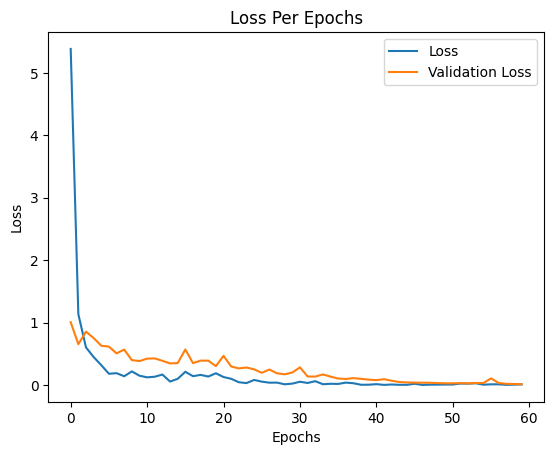

In [20]:
plt.plot(train_hist_m2[["loss", "val_loss"]])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

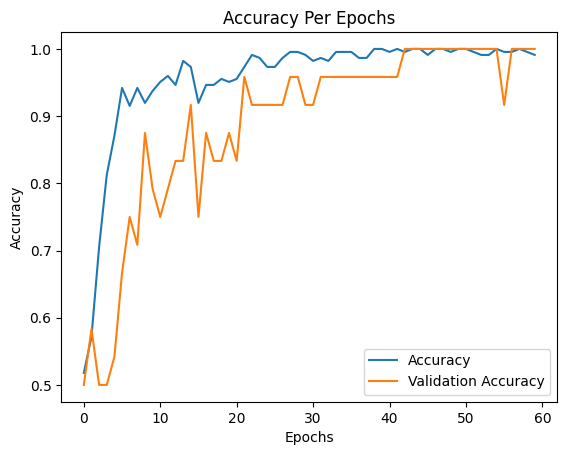

In [21]:
plt.plot(train_hist_m2[["accuracy", "val_accuracy"]])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

- - KWT Transformers Model

In [22]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from utils import mel_features

from tqdm.notebook import tqdm


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [23]:
from utils.transformer import TransformerEncoder, PatchClassEmbedding
from utils.tools import CustomSchedule

In [24]:
# model configurations
n_heads = 3 # select kwt 1 2 or 3
d_model = 64 * n_heads
d_ff = d_model * 4
mlp_head_size = 768
dropout = 0.1
activation = tf.nn.gelu
n_layers = 12

In [25]:
def build_kwt(transformer, input_size):
    # Input
    inputs = tf.keras.layers.Input(shape=input_size)
    
    # Linear Projection of Flattened Patches
    x = tf.keras.layers.Dense(d_model)(inputs)
    
    # Position Embedding + Extra learnable class embedding
    x = PatchClassEmbedding(d_model, input_size[0])(x)
    
    # Transformer Model
    x = transformer(x)
    
    # Take only the Extra Learnable Class
    x = tf.keras.layers.Lambda(lambda x: x[:,0,:])(x)
    
    # MLP Head
    x = tf.keras.layers.Dense(mlp_head_size)(x)
    outputs = tf.keras.layers.Dense(len(labels), activation='softmax')(x)
    
    return tf.keras.models.Model(inputs, outputs)


In [26]:
transformer = TransformerEncoder(d_model, n_heads, d_ff, dropout, activation, n_layers)
model = build_kwt(transformer, input_size=(X_train_reshaped.shape[1:-1]))

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 8)]           0         
                                                                 
 dense_74 (Dense)            (None, 16, 192)           1728      
                                                                 
 patch_class_embedding (Patc  (None, 17, 192)          3456      
 hClassEmbedding)                                                
                                                                 
 transformer_encoder (Transf  (None, 17, 192)          5338368   
 ormerEncoder)                                                   
                                                                 
 lambda (Lambda)             (None, 192)               0         
                                                                 
 dense_75 (Dense)            (None, 768)               148224

In [28]:
# set some variables
batch_size = 64
n_epochs = 50

In [29]:
lr = CustomSchedule(d_model, warmup_steps=20000.0)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
    metrics=['accuracy'])

In [30]:
history = model.fit(
    X_train_reshaped, y_train, 
    validation_data=(X_test_reshaped, y_test),  
    epochs=n_epochs, initial_epoch=0)

Epoch 1/50
7/7 [==============================] - 27s 898ms/step - loss: 0.8412 - accuracy: 0.4554 - val_loss: 0.8348 - val_accuracy: 0.4583
Epoch 2/50
7/7 [==============================] - 3s 403ms/step - loss: 0.8059 - accuracy: 0.4777 - val_loss: 0.8072 - val_accuracy: 0.4583
Epoch 3/50
7/7 [==============================] - 3s 405ms/step - loss: 0.7695 - accuracy: 0.4464 - val_loss: 0.7747 - val_accuracy: 0.4167
Epoch 4/50
7/7 [==============================] - 3s 422ms/step - loss: 0.7456 - accuracy: 0.4821 - val_loss: 0.7495 - val_accuracy: 0.3333
Epoch 5/50
7/7 [==============================] - 3s 384ms/step - loss: 0.7550 - accuracy: 0.4777 - val_loss: 0.7399 - val_accuracy: 0.4583
Epoch 6/50
7/7 [==============================] - 3s 386ms/step - loss: 0.7539 - accuracy: 0.4821 - val_loss: 0.7336 - val_accuracy: 0.5000
Epoch 7/50
7/7 [==============================] - 3s 381ms/step - loss: 0.7211 - accuracy: 0.5446 - val_loss: 0.7229 - val_accuracy: 0.5000
Epoch 8/50
7/7 [===

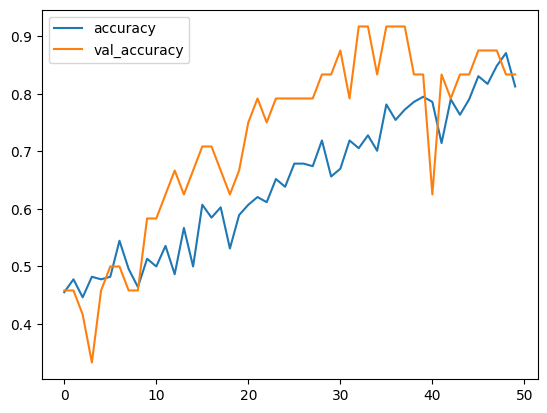

In [31]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

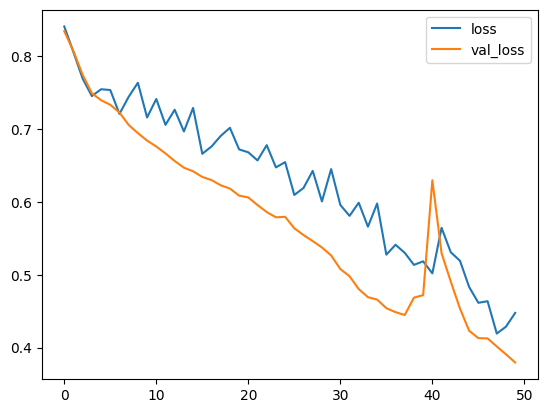

In [32]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [33]:
model.evaluate(X_test_reshaped, y_test)

1/1 [==============================] - 0s 133ms/step - loss: 0.3795 - accuracy: 0.8333


[0.3795181214809418, 0.8333333134651184]

- - CNN-2D

In [34]:
CNN2D_Model = Sequential()
CNN2D_Model.add(
    Conv2D(64, (3, 3), padding="same", activation="tanh", input_shape=(16, 8, 1))
)
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Conv2D(128, (3, 3), padding="same", activation="tanh"))
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Dropout(0.1))
CNN2D_Model.add(Flatten())
CNN2D_Model.add(Dense(1024, activation="tanh",  kernel_regularizer=regularizers.l1(l=0.01)))
CNN2D_Model.add(Dense(2, activation="softmax"))
CNN2D_Model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 8, 64)         640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 4, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 4, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 2, 128)        0         
 2D)                                                             
                                                                 
 dropout_28 (Dropout)        (None, 4, 2, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 1024)            

In [35]:
CNN2D_Model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [36]:
t0 = time.time()

CNN2D_Results = CNN2D_Model.fit(
    X_train_reshaped, y_train, epochs=100, batch_size=16, validation_data=(X_test_reshaped, y_test)
)

CNN2D_Model.save("Model3.h5")
print("CNN2D Model Saved")
train_hist_m3 = pd.DataFrame(CNN2D_Results.history)
train_m3 = round(time.time() - t0, 3)

Epoch 1/100
14/14 [==============================] - 1s 34ms/step - loss: 227.4357 - accuracy: 0.6964 - val_loss: 168.0892 - val_accuracy: 0.9583
Epoch 2/100
14/14 [==============================] - 0s 29ms/step - loss: 126.7004 - accuracy: 0.8304 - val_loss: 84.5571 - val_accuracy: 0.7500
Epoch 3/100
14/14 [==============================] - 0s 24ms/step - loss: 57.3270 - accuracy: 0.9062 - val_loss: 31.7179 - val_accuracy: 0.8750
Epoch 4/100
14/14 [==============================] - 0s 29ms/step - loss: 19.4756 - accuracy: 0.9420 - val_loss: 11.1464 - val_accuracy: 0.8750
Epoch 5/100
14/14 [==============================] - 0s 28ms/step - loss: 7.8960 - accuracy: 0.9643 - val_loss: 4.9621 - val_accuracy: 0.9167
Epoch 6/100
14/14 [==============================] - 0s 24ms/step - loss: 3.7844 - accuracy: 0.9777 - val_loss: 2.8294 - val_accuracy: 0.9167
Epoch 7/100
14/14 [==============================] - 0s 23ms/step - loss: 2.4622 - accuracy: 0.9420 - val_loss: 2.1334 - val_accuracy: 0.

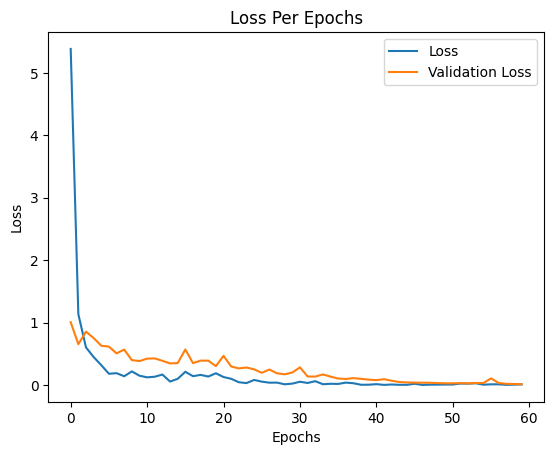

In [37]:
plt.plot(train_hist_m2[["loss", "val_loss"]])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

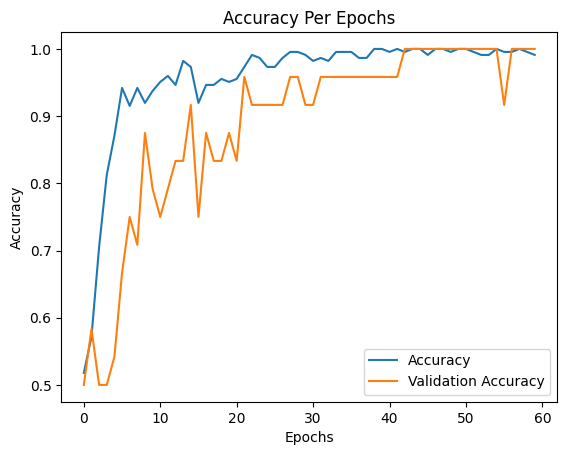

In [38]:
plt.plot(train_hist_m2[["accuracy", "val_accuracy"]])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()